Metropolis and Gibbs Sampling
====

[Kruschke's book](https://sites.google.com/site/doingbayesiandataanalysis/) begins with a fun example of a politician visiting a chain of islands to canvas support - being callow, the politician uses a simple rule to determine which island to visit next. Each day, the politician chooses a neighboring island and compares the populations there with the population of the current island. If the neighboring island has a larger population, the politician goes over. If the neighboring island has a smaller population, then the politician visits with probability $p = p_\text{neighbor} / p_\text{current}$; otherwise the politician stays on the same island. After doing this for many days, the politician will end up spending time on each island proportional to the population of each island - in other words, estimating the distribution of island populations correctly. How a simple comparison of only two states at a time can lead to accurate estimation of a probability density is the topic of the next few lectures.

Island hopping
----

In [37]:
def make_islands(n, low=10, high=101):
    islands = np.random.randint(low, high, n+2)
    islands[0] = 0
    islands[-1] = 0
    return islands

In [38]:
def hop(islands, start=1, niter=1000):
    pos = start
    pop = islands[pos]
    thetas = np.zeros(niter+1, dtype='int')
    thetas[0] = pos
    for i in range(niter):
        # generate sample from proposal distribution
        k = np.random.choice([-1, 1], 1)
        next_pos = pos + k
        # evaluate unnormalized target distribution at proposed position
        next_pop = islands[next_pos]
        # calculate acceptance probability
        p = min(1, next_pop/pop)
        # use uniform random to decide accept/reject proposal
        if np.random.random() < p:
            pos = next_pos
            pop = next_pop
        thetas[i+1] = pos
    return thetas

In [39]:
islands = make_islands(10)
thetas = hop(islands, start=1, niter=10000)

### True population proportions

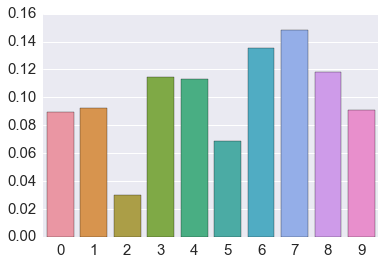

In [40]:
data = islands[1:-1]
data = data/data.sum()
sns.barplot(x=np.arange(len(data)), y=data)
pass

### Estimated population proportions

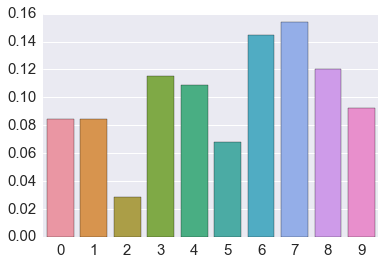

In [41]:
data = np.bincount(thetas)[1:]
data = data/data.sum()
sns.barplot(x=np.arange(len(data)), y=data)
pass

### Generic Metropolis scheme

In [42]:
def metroplis(start, target, proposal, niter, nburn=0):
    current = start
    post = [current]
    for i in range(niter):
        proposed = proposal(current)
        p = min(target(proposed)/target(current), 1)
        if np.random.random() < p:
            current = proposed
        post.append(current)
    return post[nburn:]

### Apply to island hooper

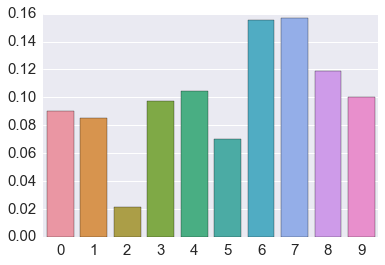

In [43]:
target = lambda x: islands[x]
proposal = lambda x: x + np.random.choice([-1, 1])
post = metroplis(1, target, proposal, 2000)
data = np.bincount(post)[1:]
data = data/data.sum()
sns.barplot(x=np.arange(len(data)), y=data)
pass

Bayesian Data Analysis
----

The fundamental objective of Bayesian data analysis is to determine the posterior distribution

$$
p(\theta \ | \ X) = \frac{p(X \ | \ \theta) p(\theta)}{p(X)}
$$

where the denominator is

$$
p(X) = \int d\theta^* p(X \ | \ \theta^*) p(\theta^*) 
$$

Here, 

- $p(X \ | \ \theta)$ is the likelihood, 
- $p(\theta)$ is the prior and 
- $p(X)$ is a normalizing constant also known as the evidence or marginal likelihood

The computational issue is the difficulty of evaluating the integral in the denominator. There are many ways to address this difficulty, including:

- In cases with conjugate priors (with conjugate priors, the posterior has the same distribution as the prior), we can get closed form solutions
- We can use numerical integration
- We can approximate the functions used to calculate the posterior with simpler functions and show that the resulting  approximate posterior is "close" to true posterior (variational Bayes)
- We can use Monte Carlo methods, of which the most important is Markov Chain Monte Carlo (MCMC). In simple Monte Carlo inegration, we want to estimate the integral $f(x) \, p(x) dx$. Wtih Bayesain models, the distribution $p(x)$ in the integral is the posterior

$$
p(x) = p(\theta \ | \ X) = \frac{p(X \ | \ \theta) p(\theta)}{\int d\theta^* p(X \ | \ \theta^*) p(\theta^*) }
$$
- MCMC allows to sample from the posterior distribution - the samples will not be independent unlike simple Monte Carlo integration, but this is OK as we can compensate for the auto-correlation by drawing a larger number  of samples.

### Motivating example

We will use the toy example of estimating the bias of a coin given a sample consisting of $n$ tosses to illustrate a few of the approaches.

#### Analytical solution

If we use a beta distribution as the prior, then the posterior distribution has a closed form solution. This is shown in the example below. Some general points:

- We need to choose a prior distribution family (i.e. the beta here) as well as its parameters (here a=10, b=10)
    - The prior distribution may be relatively uninformative (i.e. more flat) or informative (i.e. more peaked)
- The posterior depends on both the prior and the data
    - As the amount of data becomes large, the posterior approximates the MLE
    - An informative prior takes more data to shift than an uninformative one
- Of course, it is also important the model used (i.e. the likelihood) is appropriate for the fitting the data
- The mode of the posterior distribution is known as the maximum a posteriori (MAP) estimate (cf MLE which is the mode of the likelihood)

In [44]:
import scipy.stats as stats

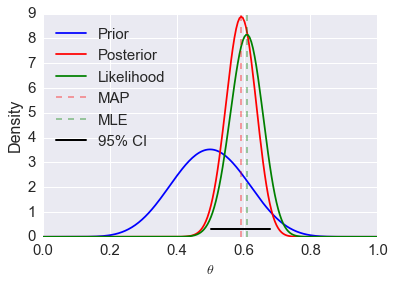

In [45]:
n = 100
h = 61
p = h/n
rv = stats.binom(n, p)
mu = rv.mean()

a, b = 10, 10
prior = stats.beta(a, b)
post = stats.beta(h+a, n-h+b)
ci = post.interval(0.95)

thetas = np.linspace(0, 1, 200)
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.plot(thetas, n*stats.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0, 1])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left')
pass

#### Numerical integration

One simple way of numerical integration is to estimate the values on a grid of values for $\theta$. To calculate the posterior, we find the prior and the likelihood for each value of $\theta$, and for the marginal likelihood, we replace the integral with the equivalent sum

$$
p(X) = \sum_{\theta^*} p(X | \theta^*) p(\theta^*) 
$$

One advantage of this is that the prior does not have to be conjugate (although the example below uses the same beta prior for ease of comparison), and so we are not restricted in our choice of an appropriate prior distribution. For example, the prior can be a mixture distribution or estimated empirically from data. The disadvantage, of course, is that this is computationally very expensive when we need to estimate multiple parameters, since the number of grid points grows as $\mathcal{O}(n^d)$, where $n$ defines the grid resolution and $d$ is the size of $\theta$.

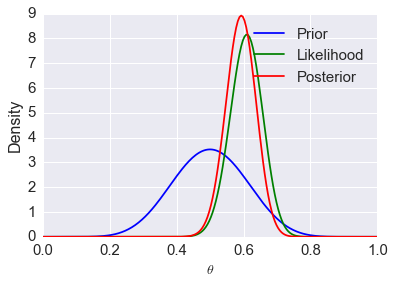

In [46]:
thetas = np.linspace(0, 1, 200)
prior = stats.beta(a, b)

post = prior.pdf(thetas) * stats.binom(n, thetas).pmf(h)
# Normalzie so volume is 1
post /= (post.sum() / len(thetas))

plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, n*stats.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.plot(thetas, post, label='Posterior', c='red')
plt.xlim([0, 1])
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend()
pass

### Markov Chain Monte Carlo (MCMC)

This lecture will only cover the basic ideas of MCMC and the 3 common variants - Metroplis, Metropolis-Hastings and Gibbs sampling. All code will be built from the ground up to illustrate what is involved in fitting an MCMC model, but only toy examples will be shown since the goal is conceptual understanding. More realistic computational examples will be shown in coming lectures using the `pymc3` and `pystan` packages.

In Bayesian statistics, we want to estimate the posterior distribution, but this is often intractable due to the high-dimensional integral in the denominator (marginal likelihood). A few other ideas we have encountered that are also relevant here are Monte Carlo integration with independent samples and the use of proposal distributions (e.g. rejection and importance sampling). As we have seen from the Monte Carlo integration lectures, we can approximate the posterior $p(\theta | X)$ if we can somehow draw many samples that come from the posterior distribution. With vanilla Monte Carlo integration, we need the samples to be independent draws from the posterior distribution, which is a problem if we do not actually know what the posterior distribution is (because we cannot integrate the marginal likelihood). 

With MCMC, we draw samples from a (simple) proposal distribution so that each draw depends only on the state of the previous draw (i.e. the samples form a Markov chain). Under certain conditions, the Markov chain will have a unique stationary distribution. In addition, not all samples are used - instead we set up acceptance criteria for each draw based on comparing successive states with respect to a target distribution that ensure that the stationary distribution is the posterior distribution of interest. The nice thing is that this target distribution only needs to be proportional to the posterior distribution, which means we don't need to evaluate the potentially intractable marginal likelihood, which is just a normalizing constant. We can find such a target distribution easily, since `posterior` $\propto$ `likelihood` $\times$ `prior`. After some time, the Markov chain of accepted draws will converge to the stationary distribution, and we can use those samples as (correlated) draws from the posterior distribution, and find functions of the posterior distribution in the same way as for vanilla Monte Carlo integration. 

There are several flavors of MCMC, but the simplest to understand is the Metropolis-Hastings random walk algorithm, and we will start there.

#### Metropolis-Hastings random walk algorithm for estimating the bias of a coin

To carry out the Metropolis-Hastings algorithm, we need to draw random samples from the following distributions

- the standard uniform distribution
- a proposal distribution $p(x)$ that we choose to be $\mathcal{N}(0, \sigma)$
- the target distribution $g(x)$ which is proportional to the posterior probability

Given an initial guess for $\theta$ with positive probability of being drawn, the Metropolis-Hastings algorithm proceeds as follows

- Choose a new proposed value ($\theta_p$) such that  $\theta_p = \theta + \Delta\theta$ where $\Delta \theta \sim \mathcal{N}(0, \sigma)$
- Caluculate the ratio

$$
\rho = \frac{g(\theta_p \ | \ X)}{g(\theta \ | \ X)} 
$$

where $g$ is the posterior probability. 

- If the proposal distribution is not symmetrical, we need to weight the acceptance probability to maintain detailed balance (reversibility) of the stationary distribution, and instead calculate

$$
\rho = \frac{g(\theta_p \ | \ X) p(\theta \ | \ \theta_p)}{g(\theta \ | \ X) p(\theta_p \ | \ \theta)} 
$$

Since we are taking ratios, the denominator cancels any distribution proportional to $g$ will also work - so we can use 

$$
\rho = \frac{p(X | \theta_p ) p(\theta_p)}{p(X | \theta ) p(\theta)}
$$
 
- If $\rho \ge 1$, then set $\theta = \theta_p$
- If $\rho \lt 1$, then set $\theta = \theta_p$ with probability $\rho$, otherwise set $\theta = \theta$ (this is where we use the standard uniform distribution)
- Repeat the earlier steps

After some number of iterations $k$, the samples $\theta_{k+1}, \theta_{k+2}, \dots$ will be samples from the posterior distributions. Here are initial concepts to help your intuition about why this is so:

- We accept a proposed move to $\theta_{k+1}$ whenever the density of the (unnormalized) target distribution at $\theta_{k+1}$ is larger than the value of $\theta_k$ - so $\theta$ will more often be found in places where the target distribution is denser
- If this was all we accepted, $\theta$ would get stuck at a local mode of the target distribution, so we also accept occasional moves to lower density regions - it turns out that the correct probability of doing so is given by the ratio $\rho$
- The acceptance criteria only looks at ratios of the target distribution, so the denominator cancels out and does not matter - that is why we only need samples from a distribution proportional to the posterior distribution
- So, $\theta$ will be expected to bounce around in such a way that its spends its time in places proportional to the density of the posterior distribution - that is, $\theta$ is a draw from the posterior distribution. 

Additional notes:

Different proposal distributions can be used for Metropolis-Hastings:

- The independence sampler uses a proposal distribution that is independent of the current value of $\theta$. In this case the proposal distribution needs to be similar to the posterior distribution for efficiency, while ensuring that the acceptance ratio is bounded in the tail region of the posterior.
- The random walk sampler (used in this example) takes a random step centered at the current value of $\theta$ - efficiency is a trade-off between small step size with high probability of acceptance and large step sizes with low probability of acceptance. Note (picture will be sketched in class) that the random walk may take a long time to traverse narrow regions of the probability distribution. Changing the step size (e.g. scaling $\Sigma$ for a multivariate normal proposal distribution) so that a target proportion of proposals are accepted is known as *tuning*.
- Much research is being conducted on different proposal distributions for efficient sampling of the posterior distribution.

We will first see a numerical example and then try to understand why it works.

In [47]:
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

n = 100
h = 61
a = 10
b = 10
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.3

naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
for i in range(niters):
    theta_p = theta + stats.norm(0, sigma).rvs() 
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2
print("Efficiency = ", naccept/niters)

Efficiency =  0.1904


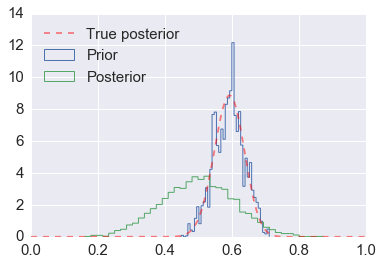

In [48]:
post = stats.beta(h+a, n-h+b)

plt.hist(samples[nmcmc:], 40, histtype='step', normed=True, linewidth=1, label='Prior');
plt.hist(prior.rvs(nmcmc), 40, histtype='step', normed=True, linewidth=1, label='Posterior');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='upper left')
pass

#### Assessing for convergence

Trace plots are often used to informally assess for stochastic convergence. Rigorous demonstration of convergence is an unsolved problem, but simple ideas such as running multiple chains and checking that they are converging to similar distributions are often employed in practice.

In [49]:
def mh_coin(niters, n, h, theta, lik, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + stats.norm(0, sigma).rvs() 
        rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)
    return samples

In [50]:
n = 100
h = 61
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.05
niters = 100

sampless = [mh_coin(niters, n, h, theta, lik, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]

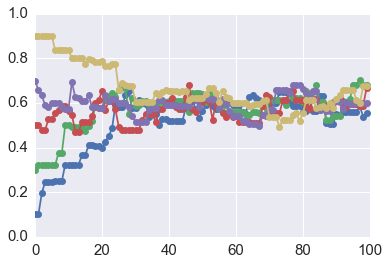

In [51]:
# Convergence of multiple chains

for samples in sampless:
    plt.plot(samples, '-o')
plt.xlim([0, niters])
plt.ylim([0, 1]);

#### Why does Metropolis-Hastings work?

There are two main ideas - first that the samples generated by MCMC constitute a Markov chain, and that this Markov chain has a unique stationary distribution that is always reached if we generate a very large number of samples. The second idea is to show that this stationary distribution is exactly the posterior distribution that we are looking for. We will only give the intuition here as a refresher.

#### One: There is a unique stationary state

Since possible transitions depend only on the current and the proposed values of $\theta$, the successive values of $\theta$ in a Metropolis-Hastings sample constitute a Markov chain. Recall that for a Markov chain with a transition matrix $T$

$$
\pi = \pi T
$$

means that $\pi$ is a stationary distribution. If it is possible to go from any state to any other state, then the matrix is irreducible. If in addition, it is not possible to get stuck in an oscillation, then the matrix is also aperiodic or mixing. For finite state spaces, irreducibility and aperiodicity guarantee the existence of a unique stationary state. For continuous state space, we need an additional property of positive recurrence - starting from any state, the expected time to come back to the original state must be finite. If we have all 3 properties of irreducibility, aperiodicity and positive recurrence, then there is a unique stationary distribution. The term ergodic is a little confusing - most standard definitions take ergodicity to be equivalent to irreducibility, but often Bayesian texts take ergodicity to mean irreducibility, aperiodicity and positive recurrence, and we will follow the latter convention. For another intuitive perspective, the random walk Metropolis-Hasting algorithm is analogous to a diffusion process. Since all states are communicating (by design), eventually the system will settle into an equilibrium state. This is analogous to converging on the stationary state. 

#### Two: The stationary state is the posterior probability distribution

We will consider the simplest possible scenario for an explicit calculation. Suppose we have a two-state system where the posterior probabilities are $\theta$ and $1 - \theta$. Suppose $\theta \lt 0.5$. So we have the following picture with the Metropolis-Hastings algorithm:

![Markov chain](mcmc.png)

and we find the stationary distribution $\pi = \left( \begin{array}{cc} p & 1-p \end{array} \right)$ by solving

$$
\begin{align}
\left( \begin{array}{cc} p & 1-p \end{array} \right) &=
\left( \begin{array}{cc} p & 1-p \end{array} \right) \left( 
\begin{array}{cc}
0 & 1  \\
\frac{\theta}{1-\theta} & 1-\frac{\theta}{1-\theta} 
\end{array} 
\right)
\end{align}
$$

to be $\pi = \left( \begin{array}{cc} \theta & 1-\theta \end{array} \right)$, which is the posterior distribution.

The final point is that a stationary distribution has to follow the detailed balance (reversibility) criterion that says that the probability of being in state $x$ and moving to state $y$ must be the same as the probability of being in state $y$ and moving to state $x$. Or, more briefly,

$$
\pi(x)T(x \to y) = \pi(y)T(y \to x)
$$

and the need to make sure that this condition is true accounts for the strange looking acceptance criterion

$$
\min \left(1, \frac{g(\theta_p \ | \ X) p(\theta \ | \ \theta_p)}{g(\theta \ | \ X) p(\theta_p \ | \ \theta)} \right)
$$

### Intuition

We want the stationary distribution $\pi(x)$ to be the posterior distribution $P(x)$. So we set

$$
P(x)T(x \to y) = P(y)T(y \to x)
$$

Rearranging, we get

$$
\frac{T(x \to y)}{T(y \to x)} = \frac{P(y)}{P(x)}
$$

We split the transition probability into separate proposal $q$ and acceptance $A$ parts, and after a little algebraic rearrangement get

$$
\frac{A(x \to y)}{A(y \to x)} = \frac{P(y) \, q(y \to x)}{P(x) \, q(x \to y)}
$$

An acceptance probability that meets this condition is
$$
A(x \to y) = \min \left(1, \frac{P(y) \, q(y \to x)}{P(x) \, q(x \to y)} \right)
$$

since $A$ in the numerator and denominator are both bounded above by 1.

See [Chib and Greenberg](https://eml.berkeley.edu/reprints/misc/understanding.pdf) for algebraic details.

### The Gibbs sampler

Suppose we have a vector of parameters $\theta = (\theta_1, \theta_2, \dots, \theta_k)$, and we want to estimate the joint posterior distribution $p(\theta | X)$. Suppose we can find and draw random samples from all the conditional distributions 

$$
p(\theta_1 | \theta_2, \dots \theta_k, X) \\
p(\theta_2 | \theta_1, \dots \theta_k, X) \\
\dots \\
p(\theta_k | \theta_1, \theta_2, \dots, X) 
$$

With Gibbs sampling, the Markov chain is constructed by sampling from the conditional distribution for each parameter $\theta_i$ in turn, treating all other parameters as observed. When we have finished iterating over all parameters, we are said to have completed one cycle of the Gibbs sampler. Since hierarchical models are typically set up as products of conditional distributions, the Gibbs sampler is ubiquitous in Bayesian modeling. Where it is difficult to sample from a conditional distribution, we can sample using a Metropolis-Hastings algorithm instead - this is known as Metropolis within Gibbs. 

Gibbs sampling is a type of random walk through parameter space, and hence can be thought of as a Metropolis-Hastings algorithm with a special proposal distribution. At each iteration in the cycle, we are drawing a proposal for a new value of a particular parameter, where the proposal distribution *is* the conditional posterior probability of that parameter. This means that the proposal move is *always* accepted. Hence, if we can draw samples from the conditional distributions, Gibbs sampling can be much more efficient than regular Metropolis-Hastings. 
More formally, we want to show that 

$$
\frac{P(y) \, q(y \to x)}{P(x) \, q(x \to y)} = 1
$$

We start by noting that $P(x_{-i}$ is the same as $P(y_{-i})$ since apart from the component $i$, the old state and the proposed new state are identical in Gibbs sampling. We also recall that 

$$P(x_i \mid x_{-i}) \, P(x_{-i}) = P(x_i, x_{-i} = P(x)$$ 

by definition of conditional probability. So we have

$$
\begin{align}
\frac{P(y) \, q(y \to x)}{P(x) \, q(x \to y)} &= \frac{P(y_i \mid y_{-1}) \, P(y_{-i})\, P(x_i \mid x_{-i}) }{P(x_i \mid x_{-i}) \, P(x_{-i})\, P(y_i \mid y_{-1})} &= 1
\end{align}
$$


**Advantages of Gibbs sampling**

- No need to tune proposal distribution
- Proposals are always accepted

**Disadvantages of Gibbs sampling**

- Need to be able to derive conditional probability distributions 
- Need to be able to (cheaply) draw random samples from conditional probability distributions
- Can be very slow if parameters are correlated because you cannot take "diagonal" steps (draw picture to illustrate)

### Motivating example
 
We will use the toy example, familiar from the EM lecture, of estimating the bias of two coins given sample pairs $(z_1, n_1)$ and $(z_2, n_2)$ where $z_i$ is the number of heads in $n_i$ tosses for coin $i$.

#### Setup

In [52]:
def bern(theta, z, N):
    """Bernoulli likelihood with N trials and z successes."""
    return np.clip(theta**z * (1-theta)**(N-z), 0, 1)

In [53]:
def bern2(theta1, theta2, z1, z2, N1, N2):
    """Bernoulli likelihood with N trials and z successes."""
    return bern(theta1, z1, N1) * bern(theta2, z2, N2)

In [54]:
def make_thetas(xmin, xmax, n):
    xs = np.linspace(xmin, xmax, n)
    widths =(xs[1:] - xs[:-1])/2.0
    thetas = xs[:-1]+ widths
    return thetas

In [55]:
from mpl_toolkits.mplot3d import Axes3D

def make_plots(X, Y, prior, likelihood, posterior, projection=None):
    fig, ax = plt.subplots(1,3, subplot_kw=dict(projection=projection, aspect='equal'), figsize=(12,3))
    if projection == '3d':
        ax[0].plot_surface(X, Y, prior, alpha=0.3, cmap=plt.cm.jet)
        ax[1].plot_surface(X, Y, likelihood, alpha=0.3, cmap=plt.cm.jet)
        ax[2].plot_surface(X, Y, posterior, alpha=0.3, cmap=plt.cm.jet)
        for ax_ in ax: ax_._axis3don = False
    else:
        ax[0].contour(X, Y, prior, cmap=plt.cm.jet)
        ax[1].contour(X, Y, likelihood, cmap=plt.cm.jet)
        ax[2].contour(X, Y, posterior, cmap=plt.cm.jet)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')     
    plt.tight_layout()

In [56]:
thetas1 = make_thetas(0, 1, 101)
thetas2 = make_thetas(0, 1, 101)
X, Y = np.meshgrid(thetas1, thetas2)

#### Analytic solution

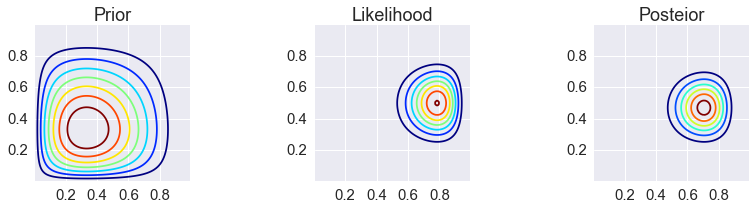

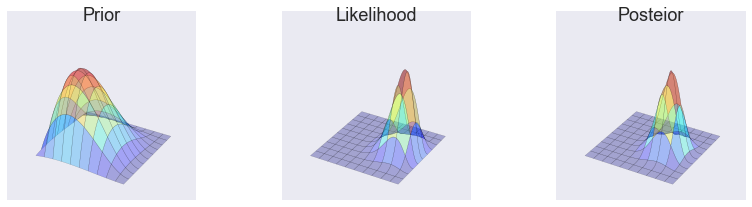

In [57]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = stats.beta(a, b).pdf(X) * stats.beta(a, b).pdf(Y)
likelihood = bern2(X, Y, z1, z2, N1, N2)
posterior = stats.beta(a + z1, b + N1 - z1).pdf(X) * stats.beta(a + z2, b + N2 - z2).pdf(Y)
make_plots(X, Y, prior, likelihood, posterior)
make_plots(X, Y, prior, likelihood, posterior, projection='3d')

#### Grid approximation

In [58]:
def c2d(thetas1, thetas2, pdf):
    width1 = thetas1[1] - thetas1[0]
    width2 = thetas2[1] - thetas2[0]
    area = width1 * width2
    pmf = pdf * area
    pmf /= pmf.sum()
    return pmf

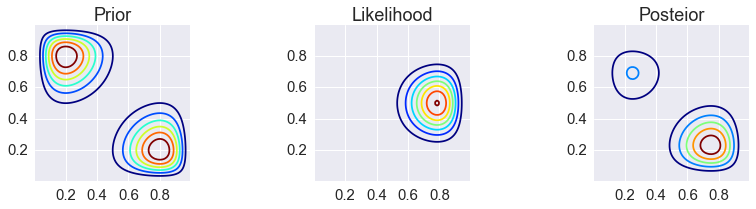

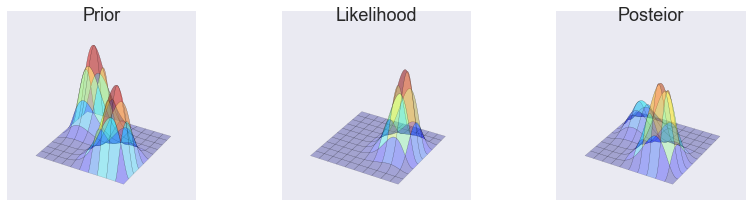

In [59]:
_prior = bern2(X, Y, 2, 8, 10, 10) + bern2(X, Y, 8, 2, 10, 10)
prior_grid = c2d(thetas1, thetas2, _prior)
_likelihood = bern2(X, Y, 1, 1, 2, 3)
posterior_grid = _likelihood * prior_grid
posterior_grid /= posterior_grid.sum()
make_plots(X, Y, prior_grid, likelihood, posterior_grid)
make_plots(X, Y, prior_grid, likelihood, posterior_grid, projection='3d')

#### Metropolis

In [60]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
lik = partial(bern2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)

theta = np.array([0.5, 0.5])
niters = 10000
burnin = 500
sigma = np.diag([0.2,0.2])

thetas = np.zeros((niters-burnin, 2), np.float)
for i in range(niters):
    new_theta = stats.multivariate_normal(theta, sigma).rvs()
    p = min(target(*new_theta)/target(*theta), 1)
    if np.random.rand() < p:
        theta = new_theta
    if i >= burnin:
        thetas[i-burnin] = theta

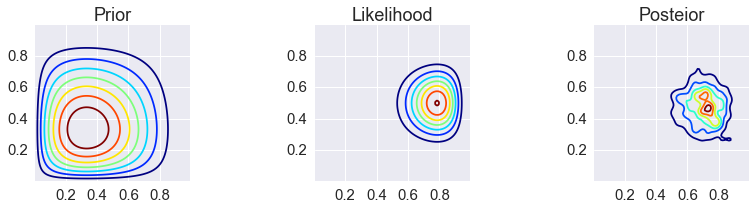

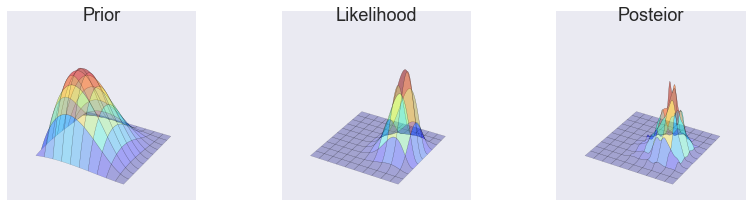

In [61]:
kde = stats.gaussian_kde(thetas.T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_metroplis = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_metroplis)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_metroplis, projection='3d')

#### Gibbs

In [62]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
lik = partial(bern2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)

theta = np.array([0.5, 0.5])
niters = 10000
burnin = 500
sigma = np.diag([0.2,0.2])

thetas = np.zeros((niters-burnin,2), np.float)
for i in range(niters):
    theta = [stats.beta(a + z1, b + N1 - z1).rvs(), theta[1]]
    theta = [theta[0], stats.beta(a + z2, b + N2 - z2).rvs()]
    
    if i >= burnin:
        thetas[i-burnin] = theta

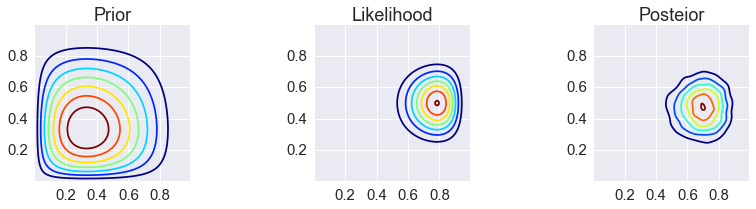

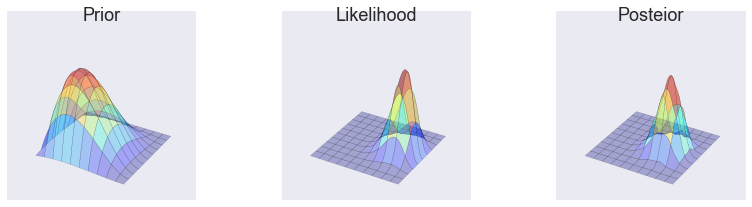

In [63]:
kde = stats.gaussian_kde(thetas.T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_gibbs = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs, projection='3d')

Hierarchical models
---

Hierarchical models have the following structure - first we specify that the data come from a distribution with parameters $\theta$

$$
X \sim f(X\ | \ \theta)
$$

and that the parameters themselves come from another distribution with hyperparameters $\lambda$

$$
\theta \sim g(\theta \ | \ \lambda)
$$

and finally that $\lambda$ comes from a prior distribution

$$ 
\lambda \sim h(\lambda)
$$

More levels of hierarchy are possible - i.e you can specify hyper-hyperparameters for the distribution of $\lambda$ and so on.

The essential idea of the hierarchical model is because the $\theta$s are not independent but rather are drawn from a common distribution with parameter $\lambda$, we can share information across the $\theta$s by also estimating $\lambda$ at the same time. 

As an example, suppose have data about the proportion of heads after some number of tosses from several coins, and we want to estimate the bias of each coin. We also know that the coins come from the same mint and so might share some common manufacturing defect. There are two extreme approaches - we could estimate the bias of each coin from its coin toss data independently of all the others, or we could pool the results together and estimate the same bias for all coins. Hierarchical models provide a compromise where we shrink individual estimates towards a common estimate.

Note that because of the conditionally independent structure of hierarchical models, Gibbs sampling is often a natural choice for the MCMC sampling strategy.

#### Gibbs sampler example from [Robert and Casella, 10.17](http://www.springer.com/statistics/statistical+theory+and+methods/book/978-0-387-21239-5)

Suppose we have data of the number of failures ($y_i$) for each of 10 pumps in a nuclear plant. We also have the times ($_i$) at which each pump was observed. We want to model the number of failures with a Poisson likelihood, where the expected number of failure $\lambda_i$ differs for each pump. Since the time which we observed each pump is different, we need to scale each $\lambda_i$ by its observed time $t_i$.

We now specify the hierarchical model - note change of notation from the overview above - that $\theta$ is $\lambda$ (parameter) and $\lambda$ is $\beta$ (hyperparameter) simply because $\lambda$ is traditional for the Poisson distribution parameter. 

The likelihood $f$ is 
$$
\prod_{i=1}^{10} \text{Poisson}(\lambda_i t_i)
$$

We let the prior $g$ for $\lambda$ be 

$$
\lambda \sim \text{Gamma}(\alpha, \beta)
$$
with $\alpha = 1.8$ (an improper prior whose integral does not sum to 1)

and let the hyperprior $h$ for $\beta$ to be 

$$
\beta \sim \text{Gamma}(\gamma, \delta)
$$

with $\gamma = 0.01$ and $\delta = 1$.

There are 11 unknown parameters (10 $\lambda$s and $\beta$) in this hierarchical model.

The posterior is 
$$
p(\lambda, \beta \ | \ y, t) = \prod_{i=1}^{10} \text{Poisson}(\lambda_i t_i) \times \text{Gamma}(\alpha, \beta) \times \text{Gamma}(\gamma, \delta)
$$

with the conditional distributions needed for Gibbs sampling given by

$$
p(\lambda_i \ | \ \lambda_{-i}, \beta, y, t) = \text{Gamma}(y_i + \alpha, t_i + \beta)
$$

and 

$$
p(\beta \ | \ \lambda, y, t) = \text{Gamma}(10\alpha + \gamma, \delta + \sum_{i=1}^10 \lambda_i)
$$

In [66]:
from numpy.random import gamma as rgamma # rename so we can use gamma for parameter name

In [67]:
def lambda_update(alpha, beta, y, t):
    return rgamma(size=len(y), shape=y+alpha, scale=1.0/(t+beta))

def beta_update(alpha, gamma, delta, lambd, y):
    return rgamma(size=1, shape=len(y) * alpha + gamma, scale=1.0/(delta + lambd.sum()))

def gibbs(niter, y, t, alpha, gamma, delta):
    lambdas_ = np.zeros((niter, len(y)), np.float)
    betas_ = np.zeros(niter, np.float)
    
    lambda_ = y/t

    for i in range(niter):
        beta_ = beta_update(alpha, gamma, delta, lambda_, y)
        lambda_ = lambda_update(alpha, beta_, y, t)

        betas_[i] = beta_
        lambdas_[i,:] = lambda_
        
    return betas_, lambdas_

#### Setup

In [68]:
alpha = 1.8
gamma = 0.01
delta = 1.0
beta0 = 1
y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22], np.int)
t = np.array([94.32, 15.72, 62.88, 125.76, 5.24, 31.44, 1.05, 1.05, 2.10, 10.48], np.float)
niter = 1000

In [69]:
betas, lambdas = gibbs(niter, y, t, alpha, gamma, delta)
print('%.3f' % betas.mean())
print('%.3f' % betas.std(ddof=1))
print(lambdas.mean(axis=0))
print(lambdas.std(ddof=1, axis=0))

2.517
0.702
[ 0.06868215  0.15056069  0.10317275  0.12202341  0.63105223  0.60574169
  0.82281696  0.80642704  1.28372441  1.83879696]
[ 0.02667919  0.08864888  0.03946587  0.03161263  0.28059977  0.13161654
  0.49599896  0.50922204  0.58418796  0.39279425]


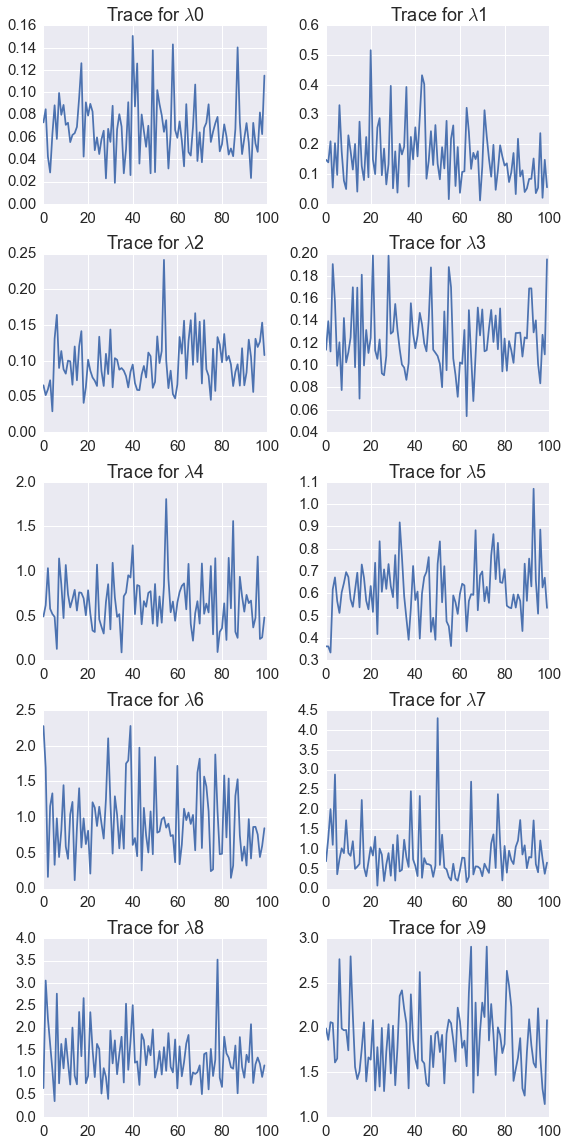

In [70]:
plt.figure(figsize=(8, 16))
for i in range(len(lambdas.T)):
    plt.subplot(5,2,i+1)
    plt.plot(lambdas[::10, i]);
    plt.title('Trace for $\lambda$%d' % i)
plt.tight_layout()

In [71]:
%load_ext version_information
%version_information numpy, scipy, matplotlib

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.5.1 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 4.0.1
OS Darwin 15.3.0 x86_64 i386 64bit
numpy 1.10.4
scipy 0.17.0
matplotlib 1.5.1
Mon Feb 29 19:45:30 2016 EST